In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy.ndimage.interpolation import zoom
from scipy.misc import imsave, imshow
import shutil

In [2]:
def load_data():
    """ Download MNIST data from TensorFlow package, """
    mnist = input_data.read_data_sets("MNIST_data", one_hot=False)
    train_data = mnist.train.images
    test_data = mnist.test.images
    valid_data = mnist.validation.images
    train_label = mnist.train.labels
    test_label = mnist.test.labels
    valid_label = mnist.validation.labels
    all_data = [valid_data, train_data, test_data]
    all_labels = [valid_label, train_label, test_label]
    return all_data, all_labels

In [3]:
all_data, all_labels = load_data()
shutil.rmtree("MNIST_data")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


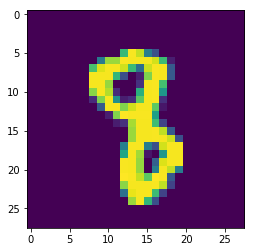

8


In [4]:
example_idx = random.randint(0,50000)
data = all_data[1]
labels = all_labels[1]

image = data[example_idx].reshape((28,28))
image_dim = 128
label_np = labels[example_idx].astype("int32")
label = label_np.tolist()

plt.imshow(image)
plt.show()
print(label)

In [5]:
def generate_cluttered_digit(input_image, image_dim, label, data):
    """
    :param input_image: input image to be stored
    :param image_dim: int, side length of square image
    :param data: entire dataset in memory from which we will pick fragments
    :param label: single integer representing the digit in the cluttered image
    :return: image_out: ndarray size image_dim x image_dim with digit randomly placed with
    8 x 8 patches of images with input noise.
    """

    # Initialize Blank image_out
    image_out = np.zeros([image_dim, image_dim])

    # Randomly Scale image
    h = np.random.randint(low=int(28/2), high=int(28*2))
    w = np.random.randint(low=int(28/2), high=int(28*2))
    digit = zoom(input_image, (h/28, w/28))

    # Randomly choose location in image_out
    x = np.random.randint(low=0, high=image_dim - w)
    y = np.random.randint(low=0, high=image_dim - h)

    # Insert digit into image_out and get max
    image_out[y:y + h, x:x + w] += digit
    max_val = image_out.max()
    
    # Tighten box
    rows = np.sum(image_out,axis=0).round(1)
    cols = np.sum(image_out,axis=1).round(1)
    
    left = np.nonzero(rows)[0][0]
    right = np.nonzero(rows)[0][-1]
    upper = np.nonzero(cols)[0][0]
    lower = np.nonzero(cols)[0][-1]
    
    # If box is too narrow or too short, pad it out to >12
    width = right - left
    if width < 12:
        pad = np.ceil((12 - width)/2)
        left  = int(left - pad)
        right = int(right + pad)
    
    height = lower - upper
    if height < 12:
        pad = np.ceil((12 - height)/2)
        upper = int(upper - pad)
        lower = int(lower + pad)

    # Save Ground Truth Bounding boxes with Label in 4th position
    if label == 0:  # Faster RCNN regards 0 as background, so change the label for all zeros to 10
        label = 10
    gt_box = [left, upper, right, lower, label]
    
    # Track "energy" in gt_box (to prevent clutter insertion)
    energy = np.sum(image_out[upper:lower, left:right])

    # Add in total number of clutter patches
    for j in range(int(image_dim/4)):

        # Randomly select MNIST digit
        index = np.random.choice(len(data))
        fragment = np.reshape(data[index, :], (28, 28))

        # Randomly select patch of selected digit
        px = np.random.randint(low=0, high=28 - 8)
        py = np.random.randint(low=0, high=28 - 8)

        # Randomly choose location to insert clutter
        x = np.random.randint(low=0, high=image_dim - 8)
        y = np.random.randint(low=0, high=image_dim - 8)
            
        # Insert digit fragment  
        image_out[y:(y+8), x:(x+8)] += fragment[py:(py+8), px:(px+8)]
        
        # Don't insert clutter into the true bounding box
        new_energy = np.sum(image_out[upper:lower, left:right])
        if energy != new_energy:
            print("invading space " + str(x) + " " + str(y))
            image_out[y:(y+8), x:(x+8)] -= fragment[py:(py+8), px:(px+8)]
            continue
        
    # Normalize any over-saturated pixels
    image_out = np.clip(image_out, 0, max_val)
        
    # Subtract mean from image and scale to be between -1 and 1
    image_out -= image_out.mean()
    image_out = image_out / np.abs(image_out).max()

    return image_out, gt_box

invading space 90 42
invading space 99 60
invading space 109 42
invading space 100 68


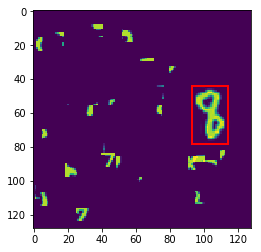

[93, 44, 114, 78, 8]
21


In [6]:
pixels, gt_box = generate_cluttered_digit(image, image_dim, label, data)
fig, ax = plt.subplots(1)
ax.imshow(pixels)
height = gt_box[3] - gt_box[1]
width = gt_box[2] - gt_box[0]
rect = patches.Rectangle((gt_box[0], gt_box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()
print(gt_box)
print(gt_box[2]-gt_box[0])